In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import Phylo
from re import sub
from tqdm import tqdm
from itertools import combinations
from matplotlib.colors import to_hex
from scipy.stats import spearmanr, mannwhitneyu
from scipy.stats import percentileofscore as posr
from statsmodels.stats.multitest import multipletests

D:\ANACONDA\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
# Calculate genus density
smorf_number = pd.read_csv('./data/figure4/cpnumber_per_tax_sum.tsv',sep= '\t',header=None,names=['taxonomy','number'])
smorf_number = smorf_number[smorf_number['taxonomy'].str.contains('g__')]
smorf_number['taxonomy'] = smorf_number['taxonomy'].str.replace('g__','')
smorf_number['rank'] = 'genus'

per_tax = pd.read_csv(r'./data/figure4/per_tax_rank.txt',sep= '\t',header=None,names=['rank','taxonomy','nbps'])

tax_number_nbps = smorf_number.merge(per_tax,'inner',on=['rank','taxonomy'])
tax_number_nbps['density'] = tax_number_nbps['number']*1e6/tax_number_nbps['nbps']
tax_number_nbps = tax_number_nbps.sort_values('density',ascending=False)

tax_number_nbps.to_csv(r'./data/figure4/density_genus.tsv',sep='\t',index=None)

In [28]:
genus_density = pd.read_csv('./data/figure4/density_genus.tsv',sep='\t')
genus_density

,taxonomy,number,rank,nbps,density
0,Hoaglandella,691,genus,691418,999.395445
1,Riesia,417,genus,504273,826.933030
2,SoCistrobi,1533,genus,2038256,752.113572
3,Algorimicrobium,207509,genus,296334931,700.251568
4,TMED78,162638,genus,273336764,595.009605
...,...,...,...,...,...
8762,Adiutrix,2193,genus,63449158,34.563106
8763,UBA8133,12899,genus,380054155,33.939900
8764,GCF-000287355,13,genus,388030,33.502564
8765,AB1-6,32,genus,979596,32.666528


In [29]:
# add error to normalized smORFs per Gbp
p = genus_density['number'] / genus_density['nbps']
genus_density['MOE'] = np.sqrt(p * (1 - p) / genus_density['nbps'])
# our confidence level is set to 95%
# then Z=1.96
genus_density['MOE'] = 1.96 * genus_density['MOE']  
# fix proportion to Gbp
genus_density['MOE'] = genus_density['MOE'] * 1e6
genus_density['VAR_pct'] = genus_density['MOE'] * 100 / genus_density['density']
genus_density

,taxonomy,number,rank,nbps,density,MOE,VAR_pct
0,Hoaglandella,691,genus,691418,999.395445,74.479592,7.452465
1,Riesia,417,genus,504273,826.933030,79.337542,9.594192
2,SoCistrobi,1533,genus,2038256,752.113572,37.636137,5.004050
3,Algorimicrobium,207509,genus,296334931,700.251568,3.011893,0.430116
4,TMED78,162638,genus,273336764,595.009605,2.890945,0.485865
...,...,...,...,...,...,...,...
8762,Adiutrix,2193,genus,63449158,34.563106,1.446579,4.185326
8763,UBA8133,12899,genus,380054155,33.939900,0.585708,1.725721
8764,GCF-000287355,13,genus,388030,33.502564,18.211896,54.359709
8765,AB1-6,32,genus,979596,32.666528,11.318190,34.647666


In [32]:
genus_density = genus_density[genus_density.VAR_pct <= 10]
genus_density.rename({'taxonomy': 'genus'}, axis=1, inplace=True)
genus_density

,genus,number,rank,nbps,density,MOE,VAR_pct
0,Hoaglandella,691,genus,691418,999.395445,74.479592,7.452465
1,Riesia,417,genus,504273,826.933030,79.337542,9.594192
2,SoCistrobi,1533,genus,2038256,752.113572,37.636137,5.004050
3,Algorimicrobium,207509,genus,296334931,700.251568,3.011893,0.430116
4,TMED78,162638,genus,273336764,595.009605,2.890945,0.485865
...,...,...,...,...,...,...,...
8758,Hydrogenivirga,898,genus,21873233,41.054745,2.685173,6.540470
8759,QNXT01,2849,genus,71802133,39.678487,1.456989,3.671988
8760,QNZU01,870,genus,22438379,38.772854,2.576415,6.644894
8762,Adiutrix,2193,genus,63449158,34.563106,1.446579,4.185326


In [43]:
tax = pd.read_table(r"./data/figure4/gtdb_r95.tsv",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])
tax

,domain,phylum,class,order,family,genus,species
0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
2,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
3,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
4,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
...,...,...,...,...,...,...,...
194595,d__Archaea,p__Micrarchaeota,c__Micrarchaeia,o__UBA8480,f__SBBD01,g__SBBD01,s__SBBD01 sp005239845
194596,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__GW2011-AR5,f__GW2011-AR5,g__GW2011-AR5,s__GW2011-AR5 sp10154u
194597,d__Archaea,p__Methanobacteriota,c__Methanococci,o__Methanococcales,f__Methanococcaceae,g__Methanotorris,s__Methanotorris formicicus
194598,d__Archaea,p__Halobacteriota,c__Halobacteria,o__Halobacteriales,f__Haladaptataceae,g__Haladaptatus,s__Haladaptatus cibarius


In [44]:
tax.drop('species', axis=1, inplace=True)
tax = tax.drop_duplicates()
tax['genus'] = [x[3:] for x in tax.genus]
tax = tax.reset_index(drop=True)
tax

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,domain,phylum,class,order,family,genus
0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,Escherichia
1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,Salmonella
2,d__Bacteria,p__Firmicutes,c__Bacilli,o__Staphylococcales,f__Staphylococcaceae,Staphylococcus
3,d__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Streptococcaceae,Streptococcus
4,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,Klebsiella
...,...,...,...,...,...,...
9423,d__Archaea,p__Thermoplasmatota,c__E2,o__DHVEG-1,f__DHVEG-1,EX4572-165
9424,d__Archaea,p__Iainarchaeota,c__Iainarchaeia,o__B1Sed10-29,f__B47-G15,B47-G15
9425,d__Archaea,p__Halobacteriota,c__Syntropharchaeia,o__ANME-1,f__ANME-1,QENH01
9426,d__Archaea,p__Asgardarchaeota,c__Lokiarchaeia,o__Helarchaeales,f__HEL-GB-A,HEL-GB-A


In [45]:
genus_density_merge = genus_density.merge(on='genus', right=tax)
genus_density_merge

,genus,number,rank,nbps,density,MOE,VAR_pct,domain,phylum,class,order,family
0,Hoaglandella,691,genus,691418,999.395445,74.479592,7.452465,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae
1,Riesia,417,genus,504273,826.933030,79.337542,9.594192,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae
2,SoCistrobi,1533,genus,2038256,752.113572,37.636137,5.004050,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae
3,Algorimicrobium,207509,genus,296334931,700.251568,3.011893,0.430116,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae
4,TMED78,162638,genus,273336764,595.009605,2.890945,0.485865,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__UBA6522,f__UBA6522
...,...,...,...,...,...,...,...,...,...,...,...,...
8673,Hydrogenivirga,898,genus,21873233,41.054745,2.685173,6.540470,d__Bacteria,p__Aquificota,c__Aquificae,o__Aquificales,f__Aquificaceae
8674,QNXT01,2849,genus,71802133,39.678487,1.456989,3.671988,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__UBA1556
8675,QNZU01,870,genus,22438379,38.772854,2.576415,6.644894,d__Bacteria,p__Campylobacterota,c__Campylobacteria,o__Campylobacterales,f__QNZT01
8676,Adiutrix,2193,genus,63449158,34.563106,1.446579,4.185326,d__Bacteria,p__Desulfobacterota,c__Desulfarculia,o__Adiutricales,f__Adiutricaceae


In [37]:
# load lineages from GTDB
gtdb_tree = Phylo.read('./data/figure4/bac120_r95.tree', 'newick')
gtdb_tree

Tree(rooted=False, weight=1.0)

In [38]:
taxaintree = [i.name for i in gtdb_tree.get_terminals()]
len(taxaintree)

30238

In [39]:
#import GTDB r95
tax_gtdb = pd.read_table("./data/figure4/gtdb_r95_genome.tsv",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])
tax_gtdb

,domain,phylum,class,order,family,genus,species
RS_GCF_000953035.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
RS_GCF_002766295.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
RS_GCF_002810665.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
RS_GCF_900636785.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
RS_GCF_003121825.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
...,...,...,...,...,...,...,...
GB_GCA_005239845.1,d__Archaea,p__Micrarchaeota,c__Micrarchaeia,o__UBA8480,f__SBBD01,g__SBBD01,s__SBBD01 sp005239845
GB_GCA_013331845.1,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__GW2011-AR5,f__GW2011-AR5,g__GW2011-AR5,s__GW2011-AR5 sp10154u
RS_GCF_000243455.1,d__Archaea,p__Methanobacteriota,c__Methanococci,o__Methanococcales,f__Methanococcaceae,g__Methanotorris,s__Methanotorris formicicus
RS_GCF_000710615.1,d__Archaea,p__Halobacteriota,c__Halobacteria,o__Halobacteriales,f__Haladaptataceae,g__Haladaptatus,s__Haladaptatus cibarius


In [40]:
#get genus id
tax_overlap = tax_gtdb.loc[taxaintree, 'genus']
tax_overlap

RS_GCF_000783395.1        g__Pseudomonas_E
RS_GCF_900580865.1        g__Pseudomonas_E
RS_GCF_900582195.1        g__Pseudomonas_E
RS_GCF_005938625.1        g__Pseudomonas_E
GB_GCA_002754355.1        g__Pseudomonas_E
                              ...         
GB_GCA_001772335.1      g__2-01-FULL-53-15
GB_GCA_001771615.1    g__OXYB2-FULL-48-7-A
GB_GCA_001771505.1      g__XYB2-FULL-36-35
GB_GCA_001771535.1      g__XYC2-FULL-37-10
GB_GCA_001771585.1      g__XYC2-FULL-46-14
Name: genus, Length: 30238, dtype: object

In [41]:
tax_overlap = tax_overlap.reset_index()
tax_overlap.rename({'index': 'genome'}, axis=1, inplace=True)
tax_overlap.genus = [x[3:] for x in tax_overlap.genus]
tax_overlap

,genome,genus
0,RS_GCF_000783395.1,Pseudomonas_E
1,RS_GCF_900580865.1,Pseudomonas_E
2,RS_GCF_900582195.1,Pseudomonas_E
3,RS_GCF_005938625.1,Pseudomonas_E
4,GB_GCA_002754355.1,Pseudomonas_E
...,...,...
30233,GB_GCA_001772335.1,2-01-FULL-53-15
30234,GB_GCA_001771615.1,OXYB2-FULL-48-7-A
30235,GB_GCA_001771505.1,XYB2-FULL-36-35
30236,GB_GCA_001771535.1,XYC2-FULL-37-10


In [42]:
# merge gtdb data
tax_overlap_merge = tax_overlap.merge(on='genus', right=genus_density_merge)
tax_overlap_merge

,genome,genus,number,rank,nbps,density,MOE,VAR_pct,domain,phylum,class,order,family
0,GB_GCA_007109405.1,VJOY01,1516,genus,11926126,127.115880,6.398507,5.033602,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae
1,RS_GCF_004327305.1,P30C,1571,genus,6425843,244.481541,12.088181,4.944415,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae
2,RS_GCF_005876905.1,SD129,2402,genus,20425871,117.595964,4.702583,3.998932,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae
3,RS_GCF_004339665.1,Azotobacter,14296,genus,81341762,175.752278,2.880790,1.639120,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae
4,RS_GCF_900110885.1,Azotobacter,14296,genus,81341762,175.752278,2.880790,1.639120,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Pseudomonadaceae
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27360,GB_GCA_001772335.1,2-01-FULL-53-15,8299,genus,84852817,97.804649,2.104173,2.151404,d__Bacteria,p__Margulisbacteria,c__WOR-1,o__O2-12-FULL-45-9,f__XYB2-FULL-48-7
27361,GB_GCA_001771615.1,OXYB2-FULL-48-7-A,2546,genus,26397325,96.449167,3.746316,3.884239,d__Bacteria,p__Margulisbacteria,c__WOR-1,o__O2-12-FULL-45-9,f__XYB2-FULL-48-7
27362,GB_GCA_001771505.1,XYB2-FULL-36-35,3990,genus,36656943,108.847047,3.377246,3.102744,d__Bacteria,p__Margulisbacteria,c__WOR-1,o__XYC2-FULL-46-14,f__XYC2-FULL-37-10
27363,GB_GCA_001771535.1,XYC2-FULL-37-10,3775,genus,32324183,116.785628,3.725303,3.189864,d__Bacteria,p__Margulisbacteria,c__WOR-1,o__XYC2-FULL-46-14,f__XYC2-FULL-37-10


In [46]:
# keep only 1 genome per taxon
ndata = tax_overlap_merge.groupby('genus').apply(lambda x: x.head(1))
ndata = ndata.reset_index(drop=True)
ndata

,genome,genus,number,rank,nbps,density,MOE,VAR_pct,domain,phylum,class,order,family
0,GB_GCA_002774085.1,0-14-0-10-38-17,11448,genus,88778855,128.949624,2.362019,1.831738,d__Bacteria,p__Patescibacteria,c__Microgenomatia,o__Shapirobacterales,f__0-14-0-10-38-17
1,GB_GCA_002774285.1,0-14-0-20-40-13,2798,genus,19105096,146.453072,5.426239,3.705104,d__Bacteria,p__Patescibacteria,c__WWE3,o__0-14-0-20-40-13,f__0-14-0-20-40-13
2,GB_GCA_002779055.1,0-14-0-20-44-26,1550,genus,10464832,148.115135,7.373225,4.978036,d__Bacteria,p__CG03,c__CG03,o__CG03,f__CG03
3,GB_GCA_002774355.1,0-14-0-20-45-22,12147,genus,98844984,122.889392,2.185291,1.778258,d__Bacteria,p__Marinisomatota,c__UBA2242,o__UBA2242,f__UBA2242
4,GB_GCA_002774685.1,0-14-0-20-51-18,4444,genus,33836678,131.336770,3.861241,2.939954,d__Bacteria,p__Elusimicrobiota,c__Elusimicrobia,o__Elusimicrobiales,f__UBA9959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8066,RS_GCF_002028455.1,Zoogloea,514668,genus,2085424243,246.792950,0.674173,0.273174,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Rhodocyclaceae
8067,RS_GCF_000428585.1,Zooshikella,4716,genus,25215188,187.030134,5.337528,2.853833,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Zooshikellaceae
8068,RS_GCF_002094855.1,Zunongwangia,36529,genus,290543260,125.726544,1.289249,1.025439,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae
8069,RS_GCF_003610015.1,Zymobacter,842,genus,8022510,104.954684,7.088903,6.754252,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Halomonadaceae


In [47]:
ndata_sort = ndata.sort_values('density',ascending=False)
ndata_sort = ndata_sort.head(3000)
ndata_sort

,genome,genus,number,rank,nbps,density,MOE,VAR_pct,domain,phylum,class,order,family
3022,RS_GCF_900044015.1,Hoaglandella,691,genus,691418,999.395445,74.479592,7.452465,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae
4931,RS_GCF_002073895.1,Riesia,417,genus,504273,826.933030,79.337542,9.594192,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae
5713,RS_GCF_900143145.1,SoCistrobi,1533,genus,2038256,752.113572,37.636137,5.004050,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae
650,RS_GCF_001678685.1,Algorimicrobium,207509,genus,296334931,700.251568,3.011893,0.430116,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae
5897,GB_GCA_002171615.1,TMED78,162638,genus,273336764,595.009605,2.890945,0.485865,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__UBA6522,f__UBA6522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,RS_GCF_003054175.1,Allosediminivita,1958,genus,11877270,164.852698,7.301465,4.429084,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae
3614,RS_GCF_001908835.1,Marivivens,32025,genus,194270318,164.847622,1.805337,1.095155,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae
6135,GB_GCA_001790525.1,UBA10212,10900,genus,66125163,164.838913,3.094331,1.877185,d__Bacteria,p__Patescibacteria,c__Saccharimonadia,o__Saccharimonadales,f__UBA10212
5887,GB_GCA_002168115.1,TMED23,49553,genus,300616048,164.838173,1.451253,0.880411,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodospirillales,f__UBA2165


In [50]:
phylum = ndata_sort.groupby('phylum').agg('size').sort_values(ascending=False)
phylum = phylum.reset_index()
phylum.columns=['phylum','number']

In [107]:
# create a hash table for genomes and genera 
taxkeys = ndata_sort[['genome', 'genus']]
taxkeys = taxkeys.set_index('genome')
taxkeys = taxkeys.to_dict()['genus']

In [52]:
# eliminate genomes without GMSC density
# or redundant
for i in tqdm(gtdb_tree.get_terminals()):
    if i.name in taxkeys: i.name = taxkeys[i.name]
    else: gtdb_tree.prune(i)

100%|███████████████████████████████████████████████████████████████████████████| 30238/30238 [00:38<00:00, 791.95it/s]


In [53]:
Phylo.write(gtdb_tree, './data/figure4/all_genus_3000.tre', 'newick')

1

In [54]:
# tree annotation in iTOL
# multibar annotation
ndata_sort[['genus', 'density','MOE']].to_csv('./data/figure4/all_genus_density.multibar_3000.txt', sep='\t', header=None, index=None)

In [55]:
phylum[:7]

,phylum,number
0,p__Proteobacteria,873
1,p__Firmicutes_A,563
2,p__Actinobacteriota,365
3,p__Firmicutes,242
4,p__Bacteroidota,161
5,p__Patescibacteria,157
6,p__Acidobacteriota,78


In [56]:
#color annotation
cmap = ['#1b9e77',
        '#d95f02',
        '#7570b3',
        '#e7298a',
        '#66a61e',
        '#e6ab02',
        '#a6761d']
phylum_color = dict()
n=0
for idx,i in enumerate(set(phylum.phylum)):
    if i in set(phylum[:7].phylum):
        phylum_color[i] = cmap[n]
        n += 1
    else:
        phylum_color[i] = '#666666'

In [57]:
ndata_sort['color'] = ndata_sort.phylum.apply(lambda x: phylum_color[x])
ndata_sort

,genome,genus,number,rank,nbps,density,MOE,VAR_pct,domain,phylum,class,order,family,color
3022,RS_GCF_900044015.1,Hoaglandella,691,genus,691418,999.395445,74.479592,7.452465,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,#1b9e77
4931,RS_GCF_002073895.1,Riesia,417,genus,504273,826.933030,79.337542,9.594192,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,#1b9e77
5713,RS_GCF_900143145.1,SoCistrobi,1533,genus,2038256,752.113572,37.636137,5.004050,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,#1b9e77
650,RS_GCF_001678685.1,Algorimicrobium,207509,genus,296334931,700.251568,3.011893,0.430116,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,#e6ab02
5897,GB_GCA_002171615.1,TMED78,162638,genus,273336764,595.009605,2.890945,0.485865,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__UBA6522,f__UBA6522,#1b9e77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,RS_GCF_003054175.1,Allosediminivita,1958,genus,11877270,164.852698,7.301465,4.429084,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,#1b9e77
3614,RS_GCF_001908835.1,Marivivens,32025,genus,194270318,164.847622,1.805337,1.095155,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,#1b9e77
6135,GB_GCA_001790525.1,UBA10212,10900,genus,66125163,164.838913,3.094331,1.877185,d__Bacteria,p__Patescibacteria,c__Saccharimonadia,o__Saccharimonadales,f__UBA10212,#d95f02
5887,GB_GCA_002168115.1,TMED23,49553,genus,300616048,164.838173,1.451253,0.880411,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodospirillales,f__UBA2165,#1b9e77


In [58]:
ndata_sort[['genus','color','phylum']].to_csv('./data/figure4/all_genus_density.colorstrip_3000.txt', sep='\t', header=None, index=None)

In [59]:
q2 = ndata_sort['density'].quantile(0.5)
print(f'Standard line representing log Q50: y={q2}')

Standard line representing log Q50: y=200.6219995720256


In [69]:
# Compare density of archaea and bacteria
# Superkingdom
smorf_number = pd.read_csv(r'./data/figure4/cpnumber_per_tax_sum.tsv',sep= '\t',header=None,names=['taxonomy','number'])
smorf_number

,taxonomy,number
0,d__Archaea,47926165
1,d__Bacteria,2180840838
2,p__Thermoplasmatota,14614793
3,p__Proteobacteria,422592141
4,p__Firmicutes_A,548204033
...,...,...
39987,s__Borreliella mayonii,1
39988,g__Doolittlea,4
39989,s__Doolittlea endobia,4
39990,s__Borreliella garinii,1


In [70]:
smorf_number = smorf_number[smorf_number['taxonomy'].str.contains('d__')]
smorf_number['taxonomy'] = smorf_number['taxonomy'].str.replace('d__','')
smorf_number['rank'] = 'superkingdom'
smorf_number

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,taxonomy,number,rank
0,Archaea,47926165,superkingdom
1,Bacteria,2180840838,superkingdom


In [71]:
per_tax = pd.read_csv(r'./data/figure4/per_tax_rank.txt',sep= '\t',header=None,names=['rank','taxonomy','nbps'])
per_tax

,rank,taxonomy,nbps
0,superkingdom,Bacteria,11349978510250
1,superkingdom,Archaea,221102729702
2,phylum,Proteobacteria,2082247967987
3,phylum,Firmicutes,335438852855
4,phylum,Actinobacteriota,1039947522867
...,...,...,...
45253,species,SBBD01 sp005239845,23201901
45254,species,GW2011-AR5 sp10154u,58072686
45255,species,Methanotorris formicicus,1928372
45256,species,Haladaptatus cibarius,2950126


In [73]:
tax_number_nbps = smorf_number.merge(per_tax,'inner',on=['rank','taxonomy'])
tax_number_nbps['density'] = tax_number_nbps['number']*1e6/tax_number_nbps['nbps']
tax_number_nbps

,taxonomy,number,rank,nbps,density
0,Archaea,47926165,superkingdom,221102729702,216.759716
1,Bacteria,2180840838,superkingdom,11349978510250,192.144931


In [75]:
# add error to normalized smORFs per Gbp
p = tax_number_nbps['number'] / tax_number_nbps['nbps']
tax_number_nbps['MOE'] = np.sqrt(p * (1 - p) / tax_number_nbps['nbps'])
# our confidence level is set to 95%
# then Z=1.96
tax_number_nbps['MOE'] = 1.96 * tax_number_nbps['MOE']  
# fix proportion to Gbp
tax_number_nbps['MOE'] = tax_number_nbps['MOE'] * 1e6
tax_number_nbps['VAR_pct'] = tax_number_nbps['MOE'] * 100 / tax_number_nbps['density']
tax_number_nbps

,taxonomy,number,rank,nbps,density,MOE,VAR_pct
0,Archaea,47926165,superkingdom,221102729702,216.759716,0.061362,0.028309
1,Bacteria,2180840838,superkingdom,11349978510250,192.144931,0.008064,0.004197


In [76]:
# Phylum
smorf_number = pd.read_csv(r'./data/figure4/cpnumber_per_tax_sum.tsv',sep= '\t',header=None,names=['taxonomy','number'])
smorf_number

,taxonomy,number
0,d__Archaea,47926165
1,d__Bacteria,2180840838
2,p__Thermoplasmatota,14614793
3,p__Proteobacteria,422592141
4,p__Firmicutes_A,548204033
...,...,...
39987,s__Borreliella mayonii,1
39988,g__Doolittlea,4
39989,s__Doolittlea endobia,4
39990,s__Borreliella garinii,1


In [77]:
smorf_number = smorf_number[smorf_number['taxonomy'].str.contains('p__')]
smorf_number['taxonomy'] = smorf_number['taxonomy'].str.replace('p__','')
smorf_number['rank'] = 'phylum'
smorf_number

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,taxonomy,number,rank
2,Thermoplasmatota,14614793,phylum
3,Proteobacteria,422592141,phylum
4,Firmicutes_A,548204033,phylum
5,Bacteroidota,348305786,phylum
6,Firmicutes_C,21825029,phylum
...,...,...,...
146,NPL-UPA2,2326,phylum
147,GCA-001730085,3700,phylum
148,Huberarchaeota,9405,phylum
149,UBP15,9671,phylum


In [81]:
tax_number_nbps = smorf_number.merge(per_tax,'inner',on=['rank','taxonomy'])
tax_number_nbps['density'] = tax_number_nbps['number']*1e6/tax_number_nbps['nbps']
phylum_density = tax_number_nbps.sort_values('density',ascending=False)
phylum_density

,taxonomy,number,rank,nbps,density
67,Desulfobacterota_D,1900430,phylum,5237203823,362.871117
84,Undinarchaeota,25085,phylum,75705315,331.350580
52,Nanoarchaeota,7712746,phylum,27413817487,281.345201
58,Methylomirabilota,13185383,phylum,54626966651,241.371319
146,Huberarchaeota,9405,phylum,39015938,241.055335
...,...,...,...,...,...
126,B64-G9,17531,phylum,233421994,75.104319
107,TA06_A,12949,phylum,173944994,74.443074
112,UBP4,6050,phylum,86172581,70.207947
105,UBA6262,5125,phylum,73573037,69.658671


In [82]:
# add error to normalized smORFs per Gbp
p = phylum_density['number'] / phylum_density['nbps']
phylum_density['MOE'] = np.sqrt(p * (1 - p) / phylum_density['nbps'])
# our confidence level is set to 95%
# then Z=1.96
phylum_density['MOE'] = 1.96 * phylum_density['MOE']  
# fix proportion to Gbp
phylum_density['MOE'] = phylum_density['MOE'] * 1e6
phylum_density['VAR_pct'] = phylum_density['MOE'] * 100 / phylum_density['density']
phylum_density

,taxonomy,number,rank,nbps,density,MOE,VAR_pct
67,Desulfobacterota_D,1900430,phylum,5237203823,362.871117,0.515827,0.142151
84,Undinarchaeota,25085,phylum,75705315,331.350580,4.099820,1.237306
52,Nanoarchaeota,7712746,phylum,27413817487,281.345201,0.198532,0.070565
58,Methylomirabilota,13185383,phylum,54626966651,241.371319,0.130270,0.053971
146,Huberarchaeota,9405,phylum,39015938,241.055335,4.871257,2.020805
...,...,...,...,...,...,...,...
126,B64-G9,17531,phylum,233421994,75.104319,1.111735,1.480255
107,TA06_A,12949,phylum,173944994,74.443074,1.282171,1.722352
112,UBP4,6050,phylum,86172581,70.207947,1.769088,2.519783
105,UBA6262,5125,phylum,73573037,69.658671,1.907081,2.737751


In [85]:
fdata = phylum_density[phylum_density.VAR_pct <= 10]
fdata.to_csv(r'./data/figure4/density_phylum.tsv',sep='\t',index=None)
fdata

,taxonomy,number,rank,nbps,density,MOE,VAR_pct
67,Desulfobacterota_D,1900430,phylum,5237203823,362.871117,0.515827,0.142151
84,Undinarchaeota,25085,phylum,75705315,331.350580,4.099820,1.237306
52,Nanoarchaeota,7712746,phylum,27413817487,281.345201,0.198532,0.070565
58,Methylomirabilota,13185383,phylum,54626966651,241.371319,0.130270,0.053971
146,Huberarchaeota,9405,phylum,39015938,241.055335,4.871257,2.020805
...,...,...,...,...,...,...,...
126,B64-G9,17531,phylum,233421994,75.104319,1.111735,1.480255
107,TA06_A,12949,phylum,173944994,74.443074,1.282171,1.722352
112,UBP4,6050,phylum,86172581,70.207947,1.769088,2.519783
105,UBA6262,5125,phylum,73573037,69.658671,1.907081,2.737751


In [86]:
fdata.rename({'taxonomy': 'phylum'}, axis=1, inplace=True)
fdata

,phylum,number,rank,nbps,density,MOE,VAR_pct
67,Desulfobacterota_D,1900430,phylum,5237203823,362.871117,0.515827,0.142151
84,Undinarchaeota,25085,phylum,75705315,331.350580,4.099820,1.237306
52,Nanoarchaeota,7712746,phylum,27413817487,281.345201,0.198532,0.070565
58,Methylomirabilota,13185383,phylum,54626966651,241.371319,0.130270,0.053971
146,Huberarchaeota,9405,phylum,39015938,241.055335,4.871257,2.020805
...,...,...,...,...,...,...,...
126,B64-G9,17531,phylum,233421994,75.104319,1.111735,1.480255
107,TA06_A,12949,phylum,173944994,74.443074,1.282171,1.722352
112,UBP4,6050,phylum,86172581,70.207947,1.769088,2.519783
105,UBA6262,5125,phylum,73573037,69.658671,1.907081,2.737751


In [87]:
tax = pd.read_table(r"./data/figure4/gtdb_r95.tsv",
                    sep='\t',
                    names=['domain', 'phylum',
                           'class', 'order',
                           'family', 'genus',
                           'species'])
tax

,domain,phylum,class,order,family,genus,species
0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
2,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
3,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
4,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri
...,...,...,...,...,...,...,...
194595,d__Archaea,p__Micrarchaeota,c__Micrarchaeia,o__UBA8480,f__SBBD01,g__SBBD01,s__SBBD01 sp005239845
194596,d__Archaea,p__Aenigmatarchaeota,c__Aenigmatarchaeia,o__GW2011-AR5,f__GW2011-AR5,g__GW2011-AR5,s__GW2011-AR5 sp10154u
194597,d__Archaea,p__Methanobacteriota,c__Methanococci,o__Methanococcales,f__Methanococcaceae,g__Methanotorris,s__Methanotorris formicicus
194598,d__Archaea,p__Halobacteriota,c__Halobacteria,o__Halobacteriales,f__Haladaptataceae,g__Haladaptatus,s__Haladaptatus cibarius


In [88]:
tax = tax[['domain','phylum']]
tax = tax.drop_duplicates()
tax['phylum'] = [x[3:] for x in tax.phylum]
tax = tax.reset_index(drop=True)
tax

,domain,phylum
0,d__Bacteria,Proteobacteria
1,d__Bacteria,Firmicutes
2,d__Bacteria,Actinobacteriota
3,d__Bacteria,Firmicutes_A
4,d__Bacteria,Campylobacterota
...,...,...
144,d__Archaea,Hydrothermarchaeota
145,d__Archaea,PWEA01
146,d__Archaea,Hadarchaeota
147,d__Archaea,EX4484-52


In [101]:
phylum_density_merge = fdata.merge(on='phylum', right=tax)
phylum_density_merge['domain'] = phylum_density_merge['domain'].str.replace('d__','')
phylum_density_merge

,phylum,number,rank,nbps,density,MOE,VAR_pct,domain
0,Desulfobacterota_D,1900430,phylum,5237203823,362.871117,0.515827,0.142151,Bacteria
1,Undinarchaeota,25085,phylum,75705315,331.350580,4.099820,1.237306,Archaea
2,Nanoarchaeota,7712746,phylum,27413817487,281.345201,0.198532,0.070565,Archaea
3,Methylomirabilota,13185383,phylum,54626966651,241.371319,0.130270,0.053971,Bacteria
4,Huberarchaeota,9405,phylum,39015938,241.055335,4.871257,2.020805,Archaea
...,...,...,...,...,...,...,...,...
144,B64-G9,17531,phylum,233421994,75.104319,1.111735,1.480255,Bacteria
145,TA06_A,12949,phylum,173944994,74.443074,1.282171,1.722352,Bacteria
146,UBP4,6050,phylum,86172581,70.207947,1.769088,2.519783,Bacteria
147,UBA6262,5125,phylum,73573037,69.658671,1.907081,2.737751,Bacteria


In [102]:
import scipy.stats as stats
bacteria = phylum_density_merge[phylum_density_merge.domain == 'Bacteria']['density'].tolist()
archaea = phylum_density_merge[phylum_density_merge.domain == 'Archaea']['density'].tolist()
statistic,pvalue=stats.mannwhitneyu(bacteria,archaea,alternative = 'two-sided')
pvalue

0.0022502161528460594

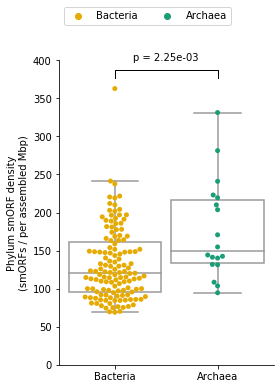

In [104]:
fig = plt.figure(figsize=(4, 5.5))
colors= ['#e6ab02','#1b9e77']
sns.set_palette(sns.color_palette(colors))

ax=sns.boxplot(
            data=phylum_density_merge,
            x='domain',
            y='density',
            showfliers=False,
            color='white',width=0.9)

sns.swarmplot(
              data=phylum_density_merge,
              x='domain',
              y='density',
              s=5,
              hue='domain' 
              )

x1, x2 = 0, 1
y,h = phylum_density_merge["density"].mean()+240,10

#绘制横线位置
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k") 
#添加P值
plt.text((x1+x2)*.5, y+h+10, 'p = 2.25e-03', ha='center', va='bottom', color="k")
plt.legend(loc=3,bbox_to_anchor=(0,1.1),ncol=2)

plt.ylim([0,400])
ax.set_xlabel('')
ax.set_ylabel('Phylum smORF density\n(smORFs / per assembled Mbp)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

In [105]:
df = pd.read_csv(r'./data/figure4/density_phylum.tsv',sep='\t')
df = df[:10]
df

,taxonomy,number,rank,nbps,density,MOE,VAR_pct
0,Desulfobacterota_D,1900430,phylum,5237203823,362.871117,0.515827,0.142151
1,Undinarchaeota,25085,phylum,75705315,331.350580,4.099820,1.237306
2,Nanoarchaeota,7712746,phylum,27413817487,281.345201,0.198532,0.070565
3,Methylomirabilota,13185383,phylum,54626966651,241.371319,0.130270,0.053971
4,Huberarchaeota,9405,phylum,39015938,241.055335,4.871257,2.020805
5,Firmicutes_A,548204033,phylum,2306240547788,237.704620,0.019896,0.008370
6,Thermoproteota,15858242,phylum,71091354574,223.068502,0.109779,0.049213
7,Dormibacterota,7074853,phylum,31915846001,221.672112,0.163328,0.073680
8,Tectomicrobia,1470061,phylum,6668276473,220.455916,0.356338,0.161637
9,Thermoplasmatota,14614793,phylum,66585838965,219.488006,0.112518,0.051264


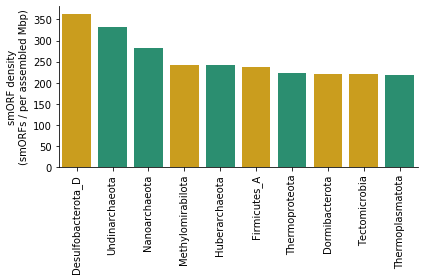

In [106]:
fig, ax = plt.subplots()
colors= ['#e6ab02','#1b9e77','#1b9e77','#e6ab02','#1b9e77','#e6ab02','#1b9e77','#e6ab02','#e6ab02','#1b9e77','#e6ab02','#e6ab02','#1b9e77','#e6ab02','#e6ab02','#1b9e77','#e6ab02','#e6ab02']
sns.barplot(data=df,x='taxonomy', y='density',palette=sns.color_palette(colors))
ax.set_xlabel('')
ax.set_ylabel('smORF density\n(smORFs / per assembled Mbp)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(df.taxonomy,rotation=90)
plt.tight_layout()